In [71]:
import torch
from torch import nn
from torch.nn.functional import threshold
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image
from copy import copy, deepcopy
from torchvision.transforms.functional import to_pil_image
import os
from unet import ConvBlock

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [72]:
class DropBlock(nn.Module):
    def __init__(self, block_size, keep_prob=0.9, sync_channel=False):
        super(DropBlock, self).__init__()
        '''
        block_size : feature에서 drop 시킬 block의 크기, 반드시 홀수여야 함.
        keep_prob : 계속 activation 시킬 Probability
        논문에서는 Keep Probability에 대해 학습을 하면서 1부터 알맞는 값까지
        선형적으로 학습하여 적합한 p값을 찾아야 한다 하지만, 그 부분은 구현이 꽤
        어려워서 0.9를 default로 모델링을 한다.
        '''
        self.block_size = block_size
        self.keep_prob = keep_prob
        self.sync_channel = sync_channel
        self.padding_size = (self.block_size-1)//2

    def getGamma(self, feat_size):
        '''
        Gamma의 역할
        Traditional한 Dropout에서 1-keep_prob을 통해 베르누이 분포를 계산하여
        Dropout을 진행하는데 이 부분이 DropBlock에서는 영역적으로
        block_size에 따라 Drop하기 때문에 이 부분을 고려하여 아래와 같이
        Gamma를 계산하여 베르누이 분포의 Drop 시킬 확률 값으로 넘기도록 한다.
        '''
        return (1.0-self.keep_prob)/(self.block_size**2)*(feat_size**2)/((feat_size-self.block_size+1)**2)

    def dropMask(self, feat_size):
        '''
        여기서 (1-keep_prob)기반 Gamma를 토대로 Bernoulli를 쓰는 것이기 때문에
        1이 Drop할 Center Pixel이다.
        '''
        mask = torch.distributions.Bernoulli(probs=self.getGamma(feat_size)).sample((feat_size, feat_size))
        return mask

    def outOfRegion(self, mask_pixel):
        '''
        Mask할 Region들이 Block Size로 인해 feature map을 넘어가지 않도록
        feature map 내에서 fully하게 Drop할 수 있도록 테두리 부분에
        Mask 픽셀이 있는 경우 이를 제거 한다.
        '''
        mask_pixel[0:self.padding_size, :] = 0.
        mask_pixel[-self.padding_size:, :] = 0.
        mask_pixel[:, 0:self.padding_size] = 0.
        mask_pixel[:, -self.padding_size:] = 0.
        return mask_pixel

    def getRegion(self, mask_region):
        masking_li = []
        for i in range(0, mask_region.shape[0]):
            for j in range(0, mask_region.shape[1]):
                if mask_region[i][j] == 1.0:
                    masking_li.append((i, j))

        for (i, j) in masking_li:
            mask_region[i-self.padding_size:i+self.padding_size+1,j-self.padding_size:j+self.padding_size+1]=1.0
        return mask_region
        
    def forward(self, x):
        feat_size = x.shape[-1]
        n_channels = x.shape[-3]
        
        if self.sync_channel:
            '''
            논문 실험에서는 channel 다 통합한 같은 Masking보다
            독립적으로 하는 게 더 성능이 좋다해서 이 부분은 사용 안 할 듯
            '''
            mask = torch.where(\
                    self.getRegion(\
                        self.outOfRegion(\
                            self.dropMask(feat_size))) == 1, 0, 1).float()
            x = x * mask
            return x
        else:
            # Channel에 따라 독립적으로 Dropout
            mask = torch.stack(
                [torch.where(\
                    self.getRegion(\
                        self.outOfRegion(\
                            self.dropMask(feat_size))) == 1, 0, 1).float()\
                                 for _ in range(n_channels)], dim=0)
            x = x * mask
            return x

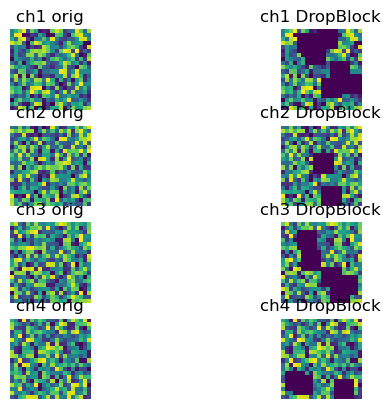

In [91]:
dropblock = DropBlock(block_size = 5, keep_prob=0.8, sync_channel=False)

channels=4
dropblock.training = False
sample = torch.rand((channels, 20, 20))
sample_db = dropblock(sample)

ch_cnt = 1
for i in range(1, channels+1):
    plt.subplot(channels, 2, i*2-1)
    plt.imshow(to_pil_image(sample[i-1]))
    plt.axis('off')
    plt.title(f'ch{ch_cnt} orig')

    plt.subplot(channels, 2, i*2)
    plt.imshow(to_pil_image(sample_db[i-1]))
    plt.axis('off')
    plt.title(f'ch{ch_cnt} DropBlock')
    ch_cnt += 1

plt.show()

In [74]:
class SpatialAttentionModule(nn.Module):
    def __init__(self):
        super(SpatialAttentionModule, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=7, stride=1, padding=3)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        maxPool = torch.max(x, dim=-3)[0]
        avgPool = torch.mean(x, dim=-3)
        concat = torch.stack([maxPool, avgPool])
        SA = self.conv(concat)
        x = x * SA
        return x

In [75]:
a = torch.rand((7, 224, 224))

SAM = SpatialAttentionModule()
b = SAM(a)
print(a.shape, b.shape)

torch.Size([7, 224, 224]) torch.Size([7, 224, 224])


In [84]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, block_size, keep_prob):
        super().__init__()

        # Block Size는 이미지 사이즈의 10%인 22로 설정
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding=1)
        self.drop1 = DropBlock(block_size=block_size, keep_prob=keep_prob)
        self.bn1 = nn.BatchNorm2d(out_filters)

        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding=1)
        self.drop2 = DropBlock(block_size=block_size, keep_prob=keep_prob)
        self.bn2 = nn.BatchNorm2d(out_filters)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        if self.training == True:
            x = self.drop1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        if self.training == True:
            x = self.drop2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        return x

In [85]:
class EncoderBlock(nn.Module):
    def __init__(self, in_filters, out_filters, block_size, keep_prob):
        super(EncoderBlock, self).__init__()

        self.convBlk = ConvBlock(in_filters, out_filters, block_size=block_size, keep_prob=keep_prob)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.convBlk(x)
        p = self.pool(x)
        return x, p

In [86]:
class DecoderBlock(nn.Module):
    def __init__(self, in_filters, out_filters, block_size, keep_prob):
        super(DecoderBlock, self).__init__()

        self.transposeConv = nn.ConvTranspose2d(in_filters, out_filters, kernel_size=2, stride=2)
        self.convBlk = ConvBlock(in_filters, out_filters, block_size=block_size, keep_prob=keep_prob)
        
    def forward(self, x, skip):
        x = self.transposeConv(x)
        x = torch.cat([x, skip], dim=1)
        x = self.convBlk(x)
        
        return x

In [87]:
class SA_UNet(nn.Module):
    def __init__(self, channel, block_size, keep_prob=0.9):
        super(SA_UNet, self).__init__()

        # Constracting Path block_size = block_size, keep_prob = keep_prob
        self.e1 = EncoderBlock(channel, 16, block_size=block_size, keep_prob=keep_prob)
        self.e2 = EncoderBlock(16, 32, block_size=block_size, keep_prob=keep_prob)
        self.e3 = EncoderBlock(32, 64, block_size=block_size, keep_prob=keep_prob)

        self.conv1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.drop1 = DropBlock(block_size=block_size, keep_prob=keep_prob)
        self.bn1 = nn.BatchNorm2d(128)

        # Bridge
        self.sam = SpatialAttentionModule()

        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.drop2 = DropBlock(block_size=block_size, keep_prob=keep_prob)
        self.bn2 = nn.BatchNorm2d(128)

        # Expanding Path
        self.d1 = DecoderBlock(128, 64, block_size=block_size, keep_prob=keep_prob)
        self.d2 = DecoderBlock(64, 32, block_size=block_size, keep_prob=keep_prob)
        self.d3 = DecoderBlock(32, 16, block_size=block_size, keep_prob=keep_prob)

        self.convOut = nn.Conv2d(16, 1, kernel_size=1, stride=1)

        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        s1, p1 = self.e1(x)
        s2, p2 = self.e2(p1)
        s3, b = self.e3(p2)

        b = self.conv1(b)
        if self.training == True:
            b = self.drop1(b)
        b = self.bn1(b)
        b = self.relu(b)

        b = self.sam(b)

        b = self.conv2(b)
        if self.training == True:
            b = self.drop2(b)
        b = self.bn2(b)
        b = self.relu(b)

        d1 = self.d1(b, s3)
        d2 = self.d2(d1, s2)
        d3 = self.d3(d2, s1)

        output = self.convOut(d3)
        output = self.sigmoid(output)

        return output

In [88]:
from torchsummary import summary

testNet = SA_UNet(channel=1, block_size=22, keep_prob=0.9)
testNet.train()
summary(testNet, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
         DropBlock-2         [-1, 16, 224, 224]               0
       BatchNorm2d-3         [-1, 16, 224, 224]              32
              ReLU-4         [-1, 16, 224, 224]               0
            Conv2d-5         [-1, 16, 224, 224]           2,320
         DropBlock-6         [-1, 16, 224, 224]               0
       BatchNorm2d-7         [-1, 16, 224, 224]              32
              ReLU-8         [-1, 16, 224, 224]               0
         ConvBlock-9         [-1, 16, 224, 224]               0
        MaxPool2d-10         [-1, 16, 112, 112]               0
     EncoderBlock-11  [[-1, 16, 224, 224], [-1, 16, 112, 112]]               0
           Conv2d-12         [-1, 32, 112, 112]           4,640
        DropBlock-13         [-1, 32, 112, 112]               0
      BatchNorm2d-14    

In [89]:
testNet.eval()
summary(testNet, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
       BatchNorm2d-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
         ConvBlock-7         [-1, 16, 224, 224]               0
         MaxPool2d-8         [-1, 16, 112, 112]               0
      EncoderBlock-9  [[-1, 16, 224, 224], [-1, 16, 112, 112]]               0
           Conv2d-10         [-1, 32, 112, 112]           4,640
      BatchNorm2d-11         [-1, 32, 112, 112]              64
             ReLU-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 32, 112, 112]           9,248
      BatchNorm2d-14    

In [90]:
print(testNet)

SA_UNet(
  (e1): EncoderBlock(
    (convBlk): ConvBlock(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop1): DropBlock()
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop2): DropBlock()
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (e2): EncoderBlock(
    (convBlk): ConvBlock(
      (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (drop1): DropBlock()
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     